<a href="https://colab.research.google.com/github/aniketsharma00411/CMPUT655-Project/blob/main/rl_project_experiment_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from popgym.envs import labyrinth_escape, labyrinth_explore
import torch
from popgym.baselines.ray_models.ray_gru import GRU

import os
import pickle
import json

import pprint
import matplotlib.pyplot as plt

# Configuration

In [2]:
num_of_cycles = 2 #@param
total_timesteps_per_cycle = 12000 #@param

In [3]:
ray.init()

2023-12-03 14:37:24,631	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.3.0


# Defining Environments

In [4]:
envs = ["LabyrinthEscapeEasy", "LabyrinthEscapeMedium", "LabyrinthEscapeHard", "LabyrinthExploreEasy", "LabyrinthExploreMedium", "LabyrinthExploreHard"]

ray.tune.registry.register_env("LabyrinthEscapeEasy", lambda env_config: labyrinth_escape.LabyrinthEscapeEasy())
ray.tune.registry.register_env("LabyrinthEscapeMedium", lambda env_config: labyrinth_escape.LabyrinthEscapeMedium())
ray.tune.registry.register_env("LabyrinthEscapeHard", lambda env_config: labyrinth_escape.LabyrinthEscapeHard())
ray.tune.registry.register_env("LabyrinthExploreEasy", lambda env_config: labyrinth_explore.LabyrinthExploreEasy())
ray.tune.registry.register_env("LabyrinthExploreMedium", lambda env_config: labyrinth_explore.LabyrinthExploreMedium())
ray.tune.registry.register_env("LabyrinthExploreHard", lambda env_config: labyrinth_explore.LabyrinthExploreHard())

# Defining Model

In [7]:
model = GRU

# Maximum episode length and backprop thru time truncation length
bptt_cutoff = 1024
# Hidden size of linear layers
h = 128
# Hidden size of memory
h_memory = 256

model_config = {
    # Truncate sequences into no more than this many timesteps
    "max_seq_len": bptt_cutoff,
    # Custom model class
    "custom_model": model,
    # Config passed to custom model constructor
    # see base_model.py to see how these are used
    "custom_model_config": {
        "preprocessor_input_size": h,
        "preprocessor": torch.nn.Sequential(
            torch.nn.Linear(h, h),
            torch.nn.LeakyReLU(inplace=True),
        ),
        "preprocessor_output_size": h,
        "hidden_size": h_memory,
        "postprocessor": torch.nn.Identity(),
        "actor": torch.nn.Sequential(
            torch.nn.Linear(h_memory, h),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(h, h),
            torch.nn.LeakyReLU(inplace=True),
        ),
        "critic": torch.nn.Sequential(
            torch.nn.Linear(h_memory, h),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(h, h),
            torch.nn.LeakyReLU(inplace=True),
        ),
        "postprocessor_output_size": h,
    },
}

# Running Experiments

In [8]:
mean_reward_per_episode = {}
timesteps_done = {}
for env in envs:
    mean_reward_per_episode[env] = []
    timesteps_done[env] = []

previous_checkpoint_path = None

In [9]:
! mkdir saved_weights

/bin/bash: /home/aniket7/miniconda3/envs/rl_project/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [10]:
total_timesteps = 0
prev_env_timesteps = 0
for cycle_count in range(num_of_cycles):
    for env in envs:
        print(f'Starting Cycle {cycle_count} Environment {env}:')
        num_splits = 1
        split_id = 1
        gpu_per_worker = 0.25

        num_workers = 4
        num_minibatch = 8
        num_envs_per_worker = 16

        train_batch_size = bptt_cutoff * \
            max(num_workers, 1) * num_envs_per_worker
        config = {
            # Environments or env names
            "env": env,
            # Should always be torch
            "framework": "torch",
            # Number of rollout workers
            "num_workers": num_workers,
            # Number of envs per rollout worker
            "num_envs_per_worker": num_envs_per_worker,
            # Num gpus used for the train worker
            "num_gpus": gpu_per_worker,
            # Loss coeff for the ppo value function
            "vf_loss_coeff": 1.0,
            # Num transitions in each training epoch
            "train_batch_size": train_batch_size,
            # Chunk size of transitions sent from rollout workers to trainer
            "rollout_fragment_length": bptt_cutoff,
            # Size of minibatches within epoch
            "sgd_minibatch_size": num_minibatch * bptt_cutoff,
            # decay gamma
            "gamma": 0.99,
            # Required due to RLlib PPO bugs
            "horizon": bptt_cutoff,
            # RLlib bug with truncate_episodes:
            # each batch the temporal dim shrinks by one
            # for now, just use complete_episodes
            "batch_mode": "complete_episodes",
            # "min_sample_timesteps_per_reporting": train_batch_size,
            "min_sample_timesteps_per_iteration": train_batch_size,
            # Describe your RL model here
            "model": model_config
        }

        trainer = PPOTrainer(env=env, config=config)
        if previous_checkpoint_path is not None:
            trainer.restore(previous_checkpoint_path+'/' +
                            sorted(os.listdir(previous_checkpoint_path))[-1])

        previous_checkpoint_path = f"saved_checkpoints/agent_cycle_{cycle_count}_env_{env}"
        curr_env_timesteps = 0
        # variables to check whether algorithm has reached weight save points
        start_checkpoint = False
        midway_checkpoint = False
        while curr_env_timesteps < total_timesteps_per_cycle:
            result = trainer.train()

            mean_reward_per_episode[env].append(result['episode_reward_mean'])
            pprint.pprint(result)
            total_timesteps = result['timesteps_total']
            curr_env_timesteps = total_timesteps - prev_env_timesteps
            timesteps_done[env].append(curr_env_timesteps)

            # save weights when training checkpoints are reached
            # 1 represents start checkpoint and 2 is midway checkpoint
            if not start_checkpoint and curr_env_timesteps > 0:
                print('Saving weights: Timesteps ', curr_env_timesteps)
                with open(f'saved_weights/weights_cycle_{cycle_count}_env_{env}_stage_1.pkl', 'wb') as f:
                    weights = trainer.get_weights()
                    pickle.dump(weights, f)
                start_checkpoint = True

            if not midway_checkpoint and curr_env_timesteps >= total_timesteps_per_cycle / 2:
                print('Saving weights: Timesteps ', curr_env_timesteps)
                with open(f'saved_weights/weights_cycle_{cycle_count}_env_{env}_stage_2.pkl', 'wb') as f:
                    weights = trainer.get_weights()
                    pickle.dump(weights, f)
                midway_checkpoint = True

        trainer.save(previous_checkpoint_path)

        prev_env_timesteps = total_timesteps

        print('\n\n')

2023-12-03 14:38:26,214	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeEasy', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeEasy').build()` instead. This will raise an error in the future!
2023-12-03 14:38:26,263	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Starting Cycle 0 Environment LabyrinthEscapeEasy:


(RolloutWorker pid=532119) 2023-12-03 14:38:30,270	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=532119) 2023-12-03 14:38:30,270	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:38:31,508	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:38:55,010	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeMedium', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeMedium').build()` instead. This will raise an error in the future!


{'agent_timesteps_total': 66929,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

(RolloutWorker pid=532951) 2023-12-03 14:38:58,996	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=532951) 2023-12-03 14:38:58,996	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:38:59,446	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:38:59,485	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthEscapeEasy/checkpoint_000001
2023-12-03 14:38:59,485	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 23.437003135681152, '_episodes_total': 91}
2023-12-03 14:39:24,137	WARNING deprecation.py:50 -- Deprecat

{'agent_timesteps_total': 133331,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=533731) 2023-12-03 14:39:28,212	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=533731) 2023-12-03 14:39:28,212	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:39:28,551	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:39:28,587	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthEscapeMedium/checkpoint_000002
2023-12-03 14:39:28,588	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 48.027270555496216, '_episodes_total': 163}
2023-12-03 14:39:57,188	WARNING deprecation.py:50 -- Depre

{'agent_timesteps_total': 201434,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=534384) 2023-12-03 14:40:01,113	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=534384) 2023-12-03 14:40:01,113	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:40:01,430	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:40:01,464	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthEscapeHard/checkpoint_000003
2023-12-03 14:40:01,465	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 76.5748679637909, '_episodes_total': 232}
2023-12-03 14:40:31,298	WARNING deprecation.py:50 -- Deprecati

{'agent_timesteps_total': 270998,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=535033) 2023-12-03 14:40:35,267	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=535033) 2023-12-03 14:40:35,267	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:40:35,664	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:40:35,700	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthExploreEasy/checkpoint_000004
2023-12-03 14:40:35,701	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 106.33671545982361, '_episodes_total': 300}
2023-12-03 14:41:05,207	WARNING deprecation.py:50 -- Deprec

{'agent_timesteps_total': 340562,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=535685) 2023-12-03 14:41:09,118	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=535685) 2023-12-03 14:41:09,118	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:41:09,565	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:41:09,601	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthExploreMedium/checkpoint_000005
2023-12-03 14:41:09,601	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': None, '_time_total': 135.78488874435425, '_episodes_total': 368}
2023-12-03 14:41:39,436	WARNING deprecation.py:50 -- Depr

{'agent_timesteps_total': 410126,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=536333) 2023-12-03 14:41:43,409	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=536333) 2023-12-03 14:41:43,409	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:41:43,891	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:41:43,924	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthExploreHard/checkpoint_000006
2023-12-03 14:41:43,925	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 165.56044673919678, '_episodes_total': 436}
2023-12-03 14:42:08,400	WARNING deprecation.py:50 -- Deprec

{'agent_timesteps_total': 477491,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=536984) 2023-12-03 14:42:12,403	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=536984) 2023-12-03 14:42:12,403	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:42:12,773	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:42:12,816	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthEscapeEasy/checkpoint_000007
2023-12-03 14:42:12,817	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 7, '_timesteps_total': None, '_time_total': 189.968035697937, '_episodes_total': 548}
2023-12-03 14:42:38,459	WARNING deprecation.py:50 -- Deprecati

{'agent_timesteps_total': 545213,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=537633) 2023-12-03 14:42:42,444	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=537633) 2023-12-03 14:42:42,444	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:42:42,885	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:42:42,922	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthEscapeMedium/checkpoint_000008
2023-12-03 14:42:42,923	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 215.56449627876282, '_episodes_total': 626}
2023-12-03 14:43:08,351	WARNING deprecation.py:50 -- Depre

{'agent_timesteps_total': 613406,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=538285) 2023-12-03 14:43:12,143	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=538285) 2023-12-03 14:43:12,143	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:43:12,733	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:43:12,767	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthEscapeHard/checkpoint_000009
2023-12-03 14:43:12,767	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 9, '_timesteps_total': None, '_time_total': 240.94591689109802, '_episodes_total': 699}
2023-12-03 14:43:38,999	WARNING deprecation.py:50 -- Depreca

{'agent_timesteps_total': 681169,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=538948) 2023-12-03 14:43:42,977	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=538948) 2023-12-03 14:43:42,977	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:43:43,297	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:43:43,336	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthExploreEasy/checkpoint_000010
2023-12-03 14:43:43,336	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 267.09295082092285, '_episodes_total': 770}
2023-12-03 14:44:13,408	WARNING deprecation.py:50 -- Depre

{'agent_timesteps_total': 750733,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

(RolloutWorker pid=539601) 2023-12-03 14:44:17,409	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=539601) 2023-12-03 14:44:17,409	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-12-03 14:44:17,882	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-12-03 14:44:17,922	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthExploreMedium/checkpoint_000011
2023-12-03 14:44:17,923	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 11, '_timesteps_total': None, '_time_total': 297.0666780471802, '_episodes_total': 838}


{'agent_timesteps_total': 820297,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'complete_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

In [11]:
ray.shutdown()

In [12]:
mean_reward_per_episode

{'LabyrinthEscapeEasy': [-0.20176210508241757, 0.09119524274553571],
 'LabyrinthEscapeMedium': [-0.7061903211805556, -0.5658303285256411],
 'LabyrinthEscapeHard': [-0.9058961730072463, -0.7067770761986302],
 'LabyrinthExploreEasy': [-0.45151156165591233, -0.07363853882221878],
 'LabyrinthExploreMedium': [-0.6031891664929502, -0.29083692413015455],
 'LabyrinthExploreHard': [-0.6996750976205697, -0.3852113578107871]}

In [13]:
with open('mean_reward_per_episode.json', 'w') as f:
    json.dump(mean_reward_per_episode, f, indent=4)

In [14]:
timesteps_done

{'LabyrinthEscapeEasy': [66929, 67365],
 'LabyrinthEscapeMedium': [66402, 67722],
 'LabyrinthEscapeHard': [68103, 68193],
 'LabyrinthExploreEasy': [69564, 67763],
 'LabyrinthExploreMedium': [69564, 69564],
 'LabyrinthExploreHard': [69564, 69564]}

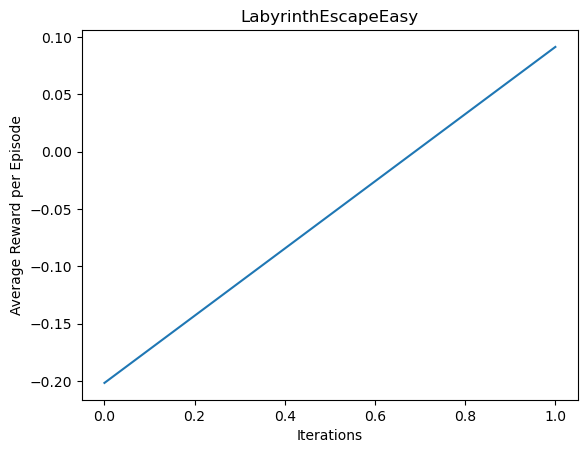

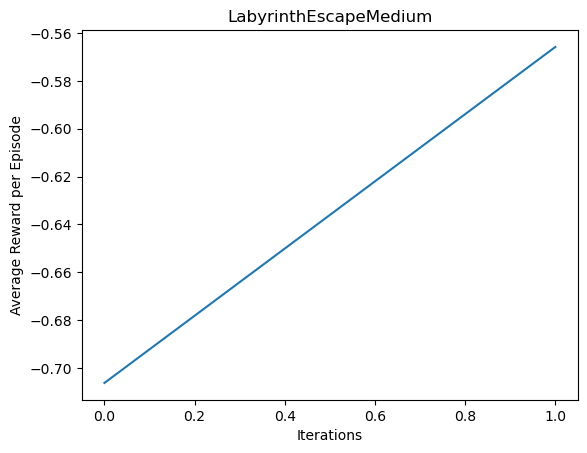

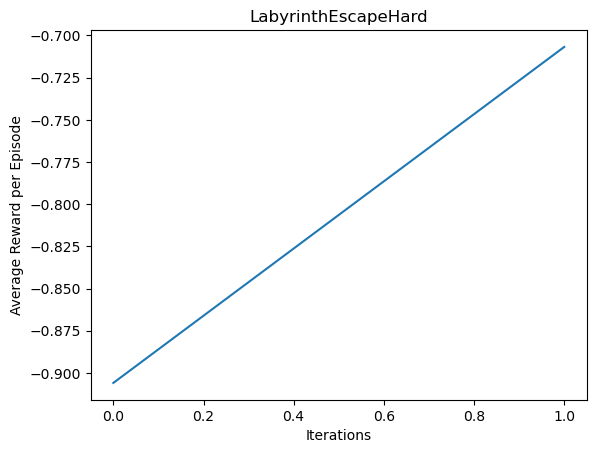

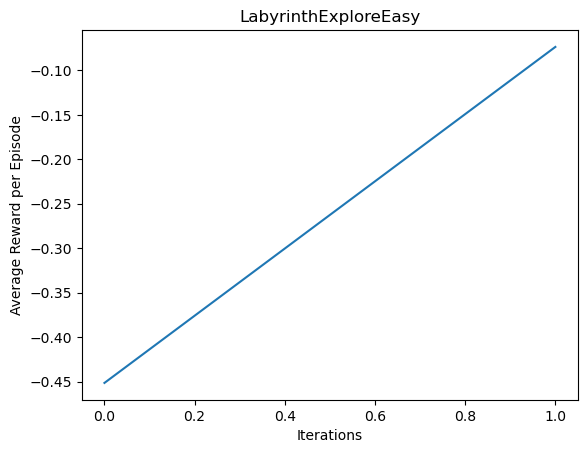

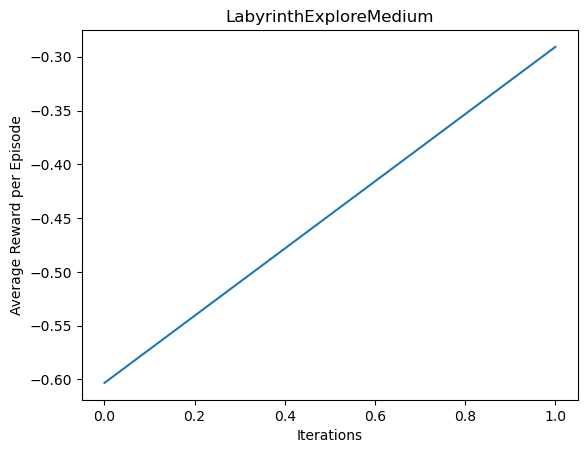

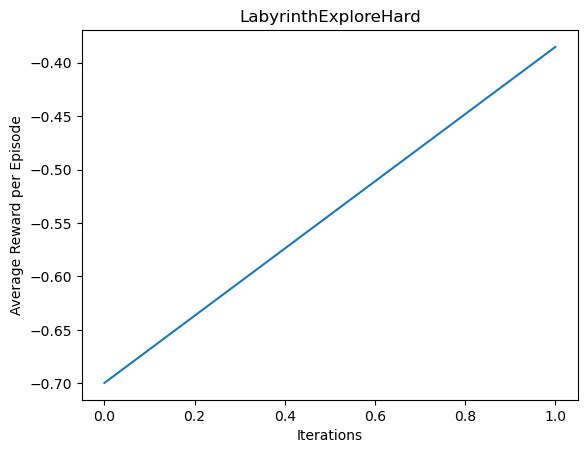

In [15]:
for env in envs:
    plt.plot(mean_reward_per_episode[env])
    plt.title(env)
    plt.xlabel('Iterations')
    plt.ylabel('Average Reward per Episode')
    plt.show()